# Pricing American options in rough Bergomi with linear and deep signatures

In this notebook we show how to use the code from https://github.com/lucapelizzari/Optimal_Stopping_with_signatures/tree/main, to compute lower and upper bounds for American options in the rough Bergomi model using different signature methods, see for example Section 4.2 of https://arxiv.org/abs/2312.03444 for the linear approach, whereas the deep neural network approaches will be discussed in a forthcoming paper.

The repository consists of:

*   Simulation packages for fractional Brownian motion, rough Bergomi and rough Heston models
*   A modul for signature related computations **Signature_computer.py**, which can compute the signature and log-signature  of various lifts related to volatility modelling, with the additional option of adding polynomials of the state-process and/or volatility.
*   The main module for the linear signature approaches **Linear_signature_optimal_stopping.py**, which can be used to derive lower and upper bounds to the optimal stopping problem applying the approaches described in https://arxiv.org/abs/2312.03444
*   The main module for deep log-signature approaches **Deep_signature_optimal_stopping.py**, which extends the linear approaches by applying deep neural networks on the log-signature. This code is accompanying a working paper paper on "American option pricing using signatures"






In [22]:
# Fix for TensorFlow import issues and environment compatibility
# Set correct Python path to find modules
import sys
import os

# Add the root directory and subdirectories to Python path
repo_root = os.path.abspath('..')
sys.path.append(repo_root)
sys.path.append(os.path.join(repo_root, "Linear signature optimal stopping"))
sys.path.append(os.path.join(repo_root, "Non linear signature optimal stopping"))

# Suppress TensorFlow warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## American Put options in the rough Bergomi model



Recall the price and volatility dynamics of the latter are given by \begin{align*}
dX_t &= rX_tdt+X_tv_t \left (\rho dW_r+\sqrt{1-\rho^2}dB_t\right ), \\ v_t & =\xi_0\mathcal{E}\left (\eta \int_0^t(t-s)^{H-\frac{1}{2}}dW_s \right )
\end{align*} and pricing an American Put-option can be formulated as optimal stopping problem $$y_0=\sup_{\tau \in \mathcal{S}_0}\mathbb{E}[e^{-r\tau}\left (K-X_{\tau}\right )^{+}]$$ for some strike $K$. In this notebook we consider the following choice of paramteres $$ H=0.07,X_0 = 100, r=0.05, \eta = 1.9, \rho = -0.9, \xi_0= 0.09, K = 110.$$


## Step 1: Simulation rough Bergomi model

We start by defining the parameters of the model and importing the rough Berogmi simulation package.

In [23]:
import numpy as np
# Define all your parameters
N1 = 14  # number of exercise-dates
N = 252  # discretization-grid
T = 14  # Maturity in days
T_years = T / 252  # Maturity in years
M = 2**17  # number of samples for training
M2 = 2**17  # number of samples for testing
H = 0.07  # Hurst parameter
eta = 1.9
X0 = 1
r = 0.05
rho = -0.9
xi = 0.09
strike = 1.05  # This is used in phi, not directly in the simulation
K = 2  # This is the depth of Signature parameter
# Your payoff function uses strike
def phi(x):
    return np.maximum(strike-x, 0)  # payoff function

Note that the number of samples should be much bigger to get reliable results, but to keep the complexity low in this presentation we restrict to $2**15$ training and testing paths here.

In [24]:
# Adjust path to include repository root
import sys
import os
sys.path.append(os.path.abspath('..'))
from rBergomi_simulation import SimulationofrBergomi

Next we define a function generating rough Bergomi prices, volatilies and the corresponding Brownian motion and payoff process. Then we generate training and testing data.

In [25]:
def generate_data(M, N, T_years, phi, rho, K, X0, H, xi, eta, r):
    X, V, I, dI, dW1, dW2, dB, Y = SimulationofrBergomi(M, N, T_years, phi, rho, K, X0, H, xi, eta, r)

    # Calculate Payoff
    Payoff = phi(X)

    # Stack state and volatility into features for signature
    MM = np.stack([X, V], axis=-1)

    return X, V, Payoff, dW1, I, MM


In [26]:
# Use K in your function call, not strike
S_training, V_training, Payoff_training, dW_training, I_training, MM_training = generate_data(M, N, T, phi, rho, K, X0, H, xi, eta, r)
S_testing, V_testing, Payoff_testing, dW_testing, I_testing, MM_testing = generate_data(M2, N, T, phi, rho, K, X0, H, xi, eta, r)

In [27]:
print("Show Head of the training data")
print("S_training", S_training[:5])
print("V_training", V_training[:5])
print("Payoff_training", Payoff_training[:5])
print("dW_training", dW_training[:5])
print("I_training", I_training[:5])
print("MM_training", MM_training[:5])


Show Head of the training data
S_training [[1.         1.01245418 1.00885189 0.99691838 1.00299428 0.98406061
  0.97479064 0.98577288 0.98765326 1.00055605 1.02758306 1.04596186
  1.04900607 1.0504907  1.05642847]
 [1.         1.03298353 1.03184662 1.03486873 1.05566327 1.05563455
  1.06180082 1.06162445 1.06425758 1.06050868 1.06485823 1.05486137
  1.05012205 1.06384281 1.06649534]
 [1.         0.97503986 0.97571065 0.97717886 0.95219762 0.92817063
  0.92279866 0.88678035 0.9127524  0.91713112 0.91000248 0.8261809
  0.84842891 0.8401957  0.76851771]
 [1.         1.0203757  1.01007883 1.03530838 1.04482952 1.04213932
  1.0694246  1.06833684 1.06729816 1.07001515 1.0833717  1.07502874
  1.0610243  1.05842682 1.05125967]
 [1.         1.0105417  1.01220105 1.02361013 1.03772722 1.03908937
  1.04126733 1.04295557 1.04764943 1.03730417 1.04039195 1.04241369
  1.0454334  1.04244252 1.0581186 ]]
V_training [[9.00000000e-02 3.54043111e-03 2.62680315e-01 7.06279264e-02
  3.76575938e-02 3.803930

In [28]:
#compute the volatility processes
vol_training = np.sqrt(V_training)
vol_testing = np.sqrt(V_testing)

## Step 2: Signature computations

We will make us uf the iisignature package https://pypi.org/project/iisignature/ to compute the signature, and it can be installed using pip:

We import our signature computation module, which can compute various signature and log signature lift related to the generated data

In [29]:
from Signature_computer import SignatureComputer

Next we initialize the **SignatureComputer**, which allows to choose from the linear and the log signature, and various choices of signature lifts. Here are some examples $$ t\mapsto \mathrm{Sig}(A_t,X_t),t\mapsto \mathrm{Sig}(A_t,\phi(X)_t),t\mapsto \mathrm{Sig}(A_t,X_t,X_{t-\epsilon}),t\mapsto \mathrm{Sig}(A_t,X_t,\phi(X_t)),t\mapsto \mathrm{Sig}(A_t,v_t),$$ where $t\mapsto A_t$ is a monoton path and in our examples we choose between $$A_t=t, \quad  A_t = \langle X\rangle_t.$$ Additonally we can add Laguerre polynomials of $X$ or $(X,v)$ to the signature, see the module for all the details.

In this example we choose the basis $(\mathrm{Sig}(t,v_t),p_i(X_t))$, which proves to be a solid choice for rough volatility models. We choose both the polynomial and signature degree to be $3$ for this example. (To improve result one should higher truncations levels ($4-5$) for the signature, but to keep the complexity reasonable here we choose level $3$ signatures.)

In [30]:
#initialize signature computer
sig_computer = SignatureComputer(T, N, 3, "linear", signature_lift="polynomial-vol", poly_degree=3)

In [31]:
#Compute the signature for training and test data
tt = np.linspace(0,T,N+1)
A_training = np.zeros((M, N+1)) #time-augmentation
A_testing = np.zeros((M2, N+1))
A_training[:, 1:] = A_testing[:, 1:] = tt[1:]
signatures_training = sig_computer.compute_signature(
    S_training, vol_training, A_training, Payoff_training,
    dW_training, I_training, MM_training
)
signatures_testing = sig_computer.compute_signature(
    S_testing, vol_testing, A_testing, Payoff_testing,
    dW_testing, I_testing, MM_testing
)

Computing linear signature with polynomial-vol lift
Computing linear signature with polynomial-vol lift


Some example of the signature paths

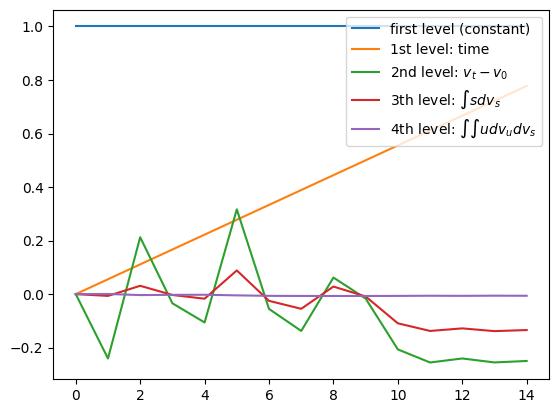

In [32]:
import matplotlib.pyplot as plt
plt.plot(signatures_training[0,:,0],label = 'first level (constant)')
plt.plot(signatures_training[0,:,1],label = '1st level: time ')
plt.plot(signatures_training[0,:,2],label = '2nd level: $v_t-v_0$')
plt.plot(signatures_training[0,:,4],label = '3th level: $\int sdv_s $')
plt.plot(signatures_training[0,:,12],label = '4th level: $\int \int udv_u dv_s $')
plt.legend(loc='upper right')


## Step 3: Compute pricing intervals with linear signatures


We can now import the linear primal and dual pricers, which compute true lower and upper bounds.
- The **LinearLongstaffSchwartzPricer** uses the signature of the training data to recursively approximate continuation values in the spirit of the Longstaff-Schwartz algorithm (descibed in detail in Section 3.1 of https://arxiv.org/abs/2312.03444). The resulting regression coefficients at each exercise date provide a stopping rule, which can be applied to the testing data to get true lower-bounds
- The **LinearDualPricer** uses the signature of the training data to minimize over the familiy of linear signature martingales, by solving a corresponding linear program (described in Detail in Section 3.2 of https://arxiv.org/abs/2312.03444). The resulting coefficients yield a Doob martingale approximation, which for the testing data yields a true upper bound.
By combining the two values, we receive confidence intervals for the true option price.

To solve the linear programm, one can optionally choose to use Gurobi https://www.gurobi.com, which requires a free licence, which is recommended especially for high-dimensional LPs, which occur when choosing large sample-sizes and/or high signature truncations levels. Alternatively, we use the free LP solvers from CVXPY

In [33]:
# ────────────────────────────────────────────────────────────────────────────────
# add root of repo and the “Linear signature optimal stopping” folder to PYTHONPATH
import sys, os
repo_root = os.path.abspath("..")  # /Users/.../Optimal_Stopping_with_signatures
ls_folder = os.path.join(repo_root, "Linear signature optimal stopping")
sys.path.extend([repo_root, ls_folder])

# now the module can be imported
from Linear_signature_optimal_stopping import LinearLongstaffSchwartzPricer, LinearDualPricer
# ────────────────────────────────────────────────────────────────────────────────

In [34]:

#initialze the models
ls_pricer = LinearLongstaffSchwartzPricer(
        N1=N1,
        T=T_years,
        r=r,
        mode="American Option",
        ridge=10**(-9)
    )

dual_pricer = LinearDualPricer(
        N1=N1,
        N=N,
        T=T_years,
        r=r,
        LP_solver="CVXPY"
    )

The choice mode="American Option" indicates that the Longstaff-Schwartz recursion will only consider "in-the-money" paths, which was originally suggested by Longstaff & Schwartz, and is reasonable for non-negative payoffs. For general payoffs we can use mode = "Standard".

In [35]:
#compute true lower bounds
lower_bound, lower_bound_std, ls_regression_models = ls_pricer.price(
        signatures_training,
        Payoff_training,
        signatures_testing,
        Payoff_testing
    )

Regression score at exercise date 13 0.9115377840307282
Regression score at exercise date 12 0.8515875063488605
Regression score at exercise date 11 0.8062383759404195
Regression score at exercise date 10 0.755539971822289
Regression score at exercise date 9 0.6970165609590369
Regression score at exercise date 8 0.64781775230349
Regression score at exercise date 7 0.5949917738082433
Regression score at exercise date 6 0.5422815270461379
Regression score at exercise date 5 0.4905739821727637
Regression score at exercise date 4 0.4176305066908803
Regression score at exercise date 3 0.33707859488420133
Regression score at exercise date 2 0.23909997784641102
Regression score at exercise date 1 0.13336249960477276


In [36]:
print(f"Linear Longstaff-Schwartz lower bound: {lower_bound} ± {lower_bound_std/np.sqrt(M2)}")

Linear Longstaff-Schwartz lower bound: 0.053620344280188206 ± 0.00012266509655457878


Similarly let us derive the upper bounds, but we will train the model only for $M= 5000$ paths to reduce computation time, and then compute true prices for all testing samples.

In [37]:
M_dual = 5000
upper_bound, upper_bound_std, MG = dual_pricer.price(
        signatures_training[:M_dual],
        Payoff_training[:M_dual],
        dW_training[:M_dual,:,0],  # Select only the first component of the Brownian increments
        signatures_testing,
        Payoff_testing,
        dW_testing[:,:,0]  # Select only the first component of the Brownian increments
    )

4.77 seconds needed to solve the linear program using CVXPY


In [38]:
print(f"Linear Dual upper bound: {upper_bound} ± {upper_bound_std/np.sqrt(M2)}")
print(f"Pricing interval: {(float(lower_bound),float(upper_bound))}± {np.maximum(upper_bound_std,lower_bound_std)/np.sqrt(M2)} ")


Linear Dual upper bound: 0.067181552774298 ± 1.469314494101849e-07
Pricing interval: (0.053620344280188206, 0.067181552774298)± 0.00012266509655457878 


# Improving the duality gap


Especially in rough regimes (here $H=0.1$), we observe a significant gap between lower and upper bounds, and in this section we present two ways to improve it. The first one still relies on linear signatures, but extends the basis as explained in in Section 4 of https://arxiv.org/abs/2312.03444.

## Part 1: Extending the linear basis

We consider a more involved basis by choosing the extended signature lift of $(t,X_t,\phi(X_t))$, and additionally add Laguerre polynomials of $(X_t,v_t)$. We can again use the SignatureComputer to compute this extended basis:

In [39]:
sig_computer_extended = SignatureComputer(T, N, 3, "linear", signature_lift="payoff-and-polynomial-extended", poly_degree=3)

In [40]:
signatures_extended_training = sig_computer_extended.compute_signature(
    S_training, vol_training, A_training, Payoff_training,
    dW_training, I_training, MM_training
)
signatures_extended_testing = sig_computer_extended.compute_signature(
    S_testing, vol_testing, A_testing, Payoff_testing,
    dW_testing, I_testing, MM_testing
)

Computing linear signature with payoff-and-polynomial-extended lift
Computing linear signature with payoff-and-polynomial-extended lift


Now we repeat the procedure for the extended basis:

In [41]:

#compute true lower bounds for the new basis
lower_bound_extended, lower_bound_extended_std, ls_regression_models_extended = ls_pricer.price(
        signatures_extended_training,
        Payoff_training,
        signatures_extended_testing,
        Payoff_testing
    )
#Repeating the dual procedure for the new basis
upper_bound_extended, upper_bound_extended_std, MG_extended = dual_pricer.price(
        signatures_extended_training[:M_dual,:,:],
        Payoff_training[:M_dual,:],
        dW_training[:M_dual,:,0],  # select first component of Brownian increments
        signatures_extended_testing,
        Payoff_testing,
        dW_testing[:,:,0]  # select first component of Brownian increments
    )

Regression score at exercise date 13 0.9120171195006237
Regression score at exercise date 12 0.8691237773219215
Regression score at exercise date 11 0.8261874387705715
Regression score at exercise date 10 0.7812251922621689
Regression score at exercise date 9 0.7228106216801085
Regression score at exercise date 8 0.6753803972051351
Regression score at exercise date 7 0.6239685161233455
Regression score at exercise date 6 0.5812610789100479
Regression score at exercise date 5 0.5235485839100782
Regression score at exercise date 4 0.4482888724578813
Regression score at exercise date 3 0.35927315779478464
Regression score at exercise date 2 0.25179943871678845
Regression score at exercise date 1 0.13809326678235068
15.25 seconds needed to solve the linear program using CVXPY


In [42]:
print(f"Improve pricing interval: {(float(lower_bound_extended),float(upper_bound_extended))}± {np.maximum(upper_bound_std,lower_bound_std)/np.sqrt(M2)} ")

Improve pricing interval: (0.05363693513009203, 0.06685287899878428)± 0.00012266509655457878 


## Part 2: Deep log-signature optimal stopping

 In forthcoming work about "American options in rough volatility models", we will focus on more non-linear apporaches to price American options. More precisely, we extend the primal and dual procecdure by replacing linear functionals of the signature by deep neural networks on the log-signature $\mathbb{L}=\mathrm{log}^\otimes(\mathbb{X})$. This transformed version of the signature still captures the relevant information about the past of the underlying process, but grows much slower as the signature it self with respect to the truncation. Then, in order to learn highly non-linear functionals, such as the integrand of the Doob martingale ("derivative of the Snell-envelope"), we apply deep feedforward neural networks $\theta$ on the log-signature. Of course, in both methods a optimization of the hyperparameters is required.

We proceed as before, but replace the linear signature by the log-signature

In [43]:
sig_computer_log = SignatureComputer(T, N, 3, "log", signature_lift="polynomial-vol", poly_degree=3)

In [44]:
log_signatures_training = sig_computer_log.compute_signature(
    S_training, vol_training, A_training, Payoff_training,
    dW_training[:,:,0], I_training, MM_training  # use first component
)
log_signatures_testing = sig_computer_log.compute_signature(
    S_testing, vol_testing, A_testing, Payoff_testing,
    dW_testing[:,:,0], I_testing, MM_testing  # use first component and correct I_testing
)

Computing log signature with polynomial-vol lift
X shape: (131072, 15), vol shape: (131072, 15), A shape: (131072, 253)
Using 15 time steps for log signature computation
Computing log signature with polynomial-vol lift
X shape: (131072, 15), vol shape: (131072, 15), A shape: (131072, 253)
Using 15 time steps for log signature computation


In [45]:
repo_root = os.path.abspath("..")  # /Users/.../Optimal_Stopping_with_signatures
ls_folder = os.path.join(repo_root, "Non linear signature optimal stopping")
sys.path.extend([repo_root, ls_folder])
from Deep_signatures_optimal_stopping import DeepLongstaffSchwartzPricer, DeepDualPricer

In [46]:
log_signatures_training = sig_computer_log.compute_signature(
    S_training, vol_training, A_training, Payoff_training,
    dW_training[:,:,0], I_training, MM_training  # use first component
)
log_signatures_testing = sig_computer_log.compute_signature(
    S_testing, vol_testing, A_testing, Payoff_testing,
    dW_testing[:,:,0], I_testing, MM_testing  # use first component and correct I_testing
)
print("shape of dW_training", dW_training.shape)
print("shape of dW_testing", dW_testing.shape)

Computing log signature with polynomial-vol lift
X shape: (131072, 15), vol shape: (131072, 15), A shape: (131072, 253)
Using 15 time steps for log signature computation
Computing log signature with polynomial-vol lift
X shape: (131072, 15), vol shape: (131072, 15), A shape: (131072, 253)
Using 15 time steps for log signature computation
shape of dW_training (131072, 14, 2)
shape of dW_testing (131072, 14, 2)


The DeepLongstaffSchwartzPricer generalizes the LinearLongstaffSchwartzPrices, where the Ridge Regression at each exercise date is replace by learning the conditional expectations via neural networks. In the following initialization we build a network with $3$ hidden layers and $16$ neurons each, between each hidden layer we apply the activation function $\mathrm{tanh}(x)$. The remainding parameters are set to 'False'. (One can run the 'Hyperparameter_optimization_primal.py' file to optimize the choice of hyperparameters)

In [47]:
ls_pricer = DeepLongstaffSchwartzPricer(
    N1=N1,
    T=T_years,
    r=r,
    mode="American Option",
    layers=3,
    nodes=16,
    activation_function='tanh',
    batch_normalization=False,
    regularizer=0.0,  # This is correct as float
    dropout=False,
    layer_normalization=False
)

dual_pricer = DeepDualPricer(
    N1=N1,
    N=N,
    T=T_years,
    r=r,
    layers=3,
    nodes=16,
    activation_function='relu',
    batch_normalization=False,
    regularizer=0.0,  # ERROR: should be float, not boolean
    dropout=False,
    attention_layer=False,
    layer_normalization=False
)
# LS pricer call is correct
lower_bound_deep, lower_bound_deep_std, ls_regression_models = ls_pricer.price(
    log_signatures_training,
    Payoff_training,
    log_signatures_testing,
    Payoff_testing,
    M_val=0,
    batch=2**8,
    epochs=15,
    learning_rate=0.001
)

# Dual pricer call is correct
y0, upper_bound_deep, upper_bound_deep_std, dual_model, dual_rule_model = dual_pricer.price(
    log_signatures_training,
    Payoff_training,
    dW_training[:,:,0],  # use only first component of Brownian increments
    log_signatures_testing,
    Payoff_testing,
    dW_testing[:,:,0],  # use only first component of Brownian increments
    M_val=int(0.9*M),
    batch=2**8,
    epochs=15,
    learning_rate=0.01
)

Regression at exercise date 13
Epoch 1/15
402/402 [==============================] - 2s 5ms/step - loss: 0.0068 - mae: 0.0381
Epoch 2/15
402/402 [==============================] - 2s 4ms/step - loss: 3.5770e-04 - mae: 0.0123
Epoch 3/15
402/402 [==============================] - 2s 4ms/step - loss: 3.4104e-04 - mae: 0.0117
Epoch 4/15
402/402 [==============================] - 2s 4ms/step - loss: 3.3886e-04 - mae: 0.0117
Epoch 5/15
402/402 [==============================] - 2s 4ms/step - loss: 3.3928e-04 - mae: 0.0117
Epoch 6/15
402/402 [==============================] - 2s 4ms/step - loss: 3.3773e-04 - mae: 0.0117
Epoch 7/15
402/402 [==============================] - 2s 4ms/step - loss: 3.3759e-04 - mae: 0.0117
Epoch 8/15
402/402 [==============================] - 2s 4ms/step - loss: 3.3876e-04 - mae: 0.0117
Epoch 9/15
402/402 [==============================] - 2s 4ms/step - loss: 3.3968e-04 - mae: 0.0118
Epoch 10/15
402/402 [==============================] - 2s 4ms/step - loss: 3.3925e

Similarly for the dual problem, we consider the same network but use the $relu(x)$ activation instead.

In [48]:
# Consistent parameter usage for validation set size
M_val_percentage = 0.9

The Deep Longstaff Schwartz uses $15$ epochs for at the last exercise date, and then one epochs at the remainding ones by initiliazing smartly. The learning rate for the Stochastic Gradient Descent is choosen as $0.001$, and we use batch sizes of $2^8$.

In [49]:
print(f"Deep Longstaff-Schwartz lower bound: {lower_bound_deep} ± {lower_bound_deep_std/np.sqrt(M2)}")

Deep Longstaff-Schwartz lower bound: 0.05005361095340205 ± 7.127670084829288e-05


In [50]:
print(f"Deep Dual upper bound: {upper_bound_deep} ± {upper_bound_deep_std/np.sqrt(M2)}")
print(f"Pricing interval: {(lower_bound_deep,upper_bound_deep)}± {np.maximum(upper_bound_deep_std,lower_bound_deep_std)/np.sqrt(M2)} ")

Deep Dual upper bound: 0.0715030415031311 ± 6.832770578573121e-05
Pricing interval: (0.05005361095340205, 0.0715030415031311)± 7.127670084829288e-05 


In [51]:
repo_root = os.path.abspath("..")  # /Users/.../Optimal_Stopping_with_signatures
ls_folder = os.path.join(repo_root, "Non linear signature optimal stopping")
sys.path.extend([repo_root, ls_folder])
from Deep_kernel_signature_optimal_stopping import DeepKernelLongstaffSchwartzPricer, DeepKernelDualPricer


In [52]:
# Cell 1: Define the RFF feature computation functions with corrected implementation

def compute_rff_kernel_features(signatures, N1, rff_dim=128, gamma=1.0):
    """
    Compute Random Fourier Features for lower bound pricer (list format)
    
    Args:
        signatures: Signature data with shape [M, T_steps, feature_dim]
        N1: Number of exercise dates
        rff_dim: Dimension of random features (default: 128)
        gamma: RBF kernel bandwidth parameter (default: 1.0)
    
    Returns:
        List of tensors with shape [M, rff_dim*2, 1] for each exercise date
    """
    M, T_steps, feature_dim = signatures.shape
    
    # Calculate indices based on actual data dimensions
    actual_steps = T_steps - 1
    subindex = [min(int((j+1)*actual_steps/N1), actual_steps) for j in range(N1)]
    
    print(f"Signature data has {T_steps} time points")
    print(f"Using exercise indices: {subindex}")
    
    # Create list to hold RFF features for each exercise date
    rff_features_list = []
    
    # For each exercise date
    for t in range(len(subindex)):
        idx = min(subindex[t], T_steps-1)
        X_t = signatures[:, idx, :]
        
        # Generate random projection matrix for RBF kernel approximation
        np.random.seed(42 + t)  # Different seed for each exercise date
        W = np.random.normal(0, np.sqrt(2*gamma), (feature_dim, rff_dim))
        
        # Compute RFF: [cos(Wx), sin(Wx)]
        projection = X_t @ W
        rff_features = np.column_stack([
            np.cos(projection),
            np.sin(projection)
        ]) * np.sqrt(1/rff_dim)
        
        # Reshape to match expected format: [M, rff_dim*2, 1]
        rff_features = rff_features.reshape(M, rff_dim*2, 1)
        
        rff_features_list.append(rff_features)
    
    return rff_features_list

def compute_rff_kernel_features_dual(signatures, N, N1, rff_dim=128, gamma=1.0):
    """
    Compute Random Fourier Features for dual pricer (3D tensor format)
    
    Args:
        signatures: Signature data with shape [M, T_steps, feature_dim]
        N: Number of time steps in the discretization
        N1: Number of exercise dates
        rff_dim: Dimension of random features (default: 128)
        gamma: RBF kernel bandwidth parameter (default: 1.0)
    
    Returns:
        Tensor with shape [M, features, time] for all time points
    """
    M, T_steps, feature_dim = signatures.shape
    
    # Calculate indices proportional to exercise dates
    # We need to map our exercise indices to the full discretization grid
    actual_steps = min(T_steps - 1, N)
    all_indices = np.minimum(np.array([int(t * T_steps / (N+1)) for t in range(N+1)]), T_steps-1)
    
    print(f"Using exercise indices for dual pricer: {all_indices[:5]}...{all_indices[-5:]}")
    
    # Generate random projection matrix once
    np.random.seed(42)
    W = np.random.normal(0, np.sqrt(2*gamma), (feature_dim, rff_dim))
    
    # Extract all required signature data at once
    X_all = signatures[:, all_indices, :]  # Shape: [M, N+1, feature_dim]
    
    # Reshape for batch matrix multiplication
    X_reshaped = X_all.reshape(-1, feature_dim)  # Shape: [M*(N+1), feature_dim]
    
    # Compute all projections at once
    projections = X_reshaped @ W  # Shape: [M*(N+1), rff_dim]
    
    # Compute RFF features
    cos_features = np.cos(projections)
    sin_features = np.sin(projections)
    rff_features = np.column_stack([cos_features, sin_features]) * np.sqrt(1/rff_dim)
    
    # Reshape back to original dimensions
    full_rff = rff_features.reshape(M, N+1, rff_dim*2)
    
    # Transpose to match expected format: [M, features, time]
    return np.transpose(full_rff, (0, 2, 1))

In [53]:
# Cell 2: Calculate and use RFF features for pricing with corrected implementation

# Calculate both sets of features
rff_dim = 64
print("Computing kernel features for lower bound...")
kernel_training = compute_rff_kernel_features(log_signatures_training, N1, rff_dim=rff_dim)
kernel_testing = compute_rff_kernel_features(log_signatures_testing, N1, rff_dim=rff_dim)

# IMPORTANT: For the dual approach, we need to generate features for N1 steps
print("Computing kernel features for upper bound...")
kernel_training_dual = compute_rff_kernel_features_dual(log_signatures_training, N1, N1, rff_dim=rff_dim)
kernel_testing_dual = compute_rff_kernel_features_dual(log_signatures_testing, N1, N1, rff_dim=rff_dim)
print("Initializing kernel-based lower bound...")
# 1. LOWER BOUND calculation - this works correctly
kernel_pricer = DeepKernelLongstaffSchwartzPricer(
    N1=N1,
    T=T_years,
    r=r,
    L=rff_dim*2,
    mode="American Option",
    layers=3,
    nodes=32,
    activation_function='relu',
    batch_normalization=True,
    regularizer=0.001,
    dropout=False,
    layer_normalization=True
)

print("Computing kernel-based lower bound...")
lower_bound_kernel, lower_bound_kernel_std, kernel_models = kernel_pricer.price(
    kernel_training,
    kernel_testing,
    Payoff_training,
    Payoff_testing,
    batch=2**8,
    epochs=15,
    learning_rate=0.0005
)

# 2. UPPER BOUND calculation - use direct payoff, no need to expand
print("Initializing kernel-based upper bound...")
kernel_dual_pricer = DeepKernelDualPricer(
    N1=N1,
    N=N1,  # Using N1 instead of N=252 here is the key change
    T=T_years,
    r=r,
    layers=4,
    nodes=32,
    activation_function='relu',
    batch_normalization=True,
    regularizer=0.001,
    dropout=True,
    attention_layer=False,
    layer_normalization=True,
    mode_dim="1-dim"
)
print("Computing kernel-based upper bound...")
try:
    y0_kernel, upper_bound_kernel, upper_bound_kernel_std, kernel_model, kernel_rule_model = kernel_dual_pricer.price(
        kernel_training_dual,
        Payoff_training,
        dW_training[:,:,0],
        kernel_testing_dual,
        Payoff_testing,      
        dW_testing[:,:,0],
        M_val=int(0.9*M),
        batch=2**8,
        epochs=15,
        learning_rate=0.0005
    )
    
    # Report results
    print(f"Deep Kernel Longstaff-Schwartz lower bound: {lower_bound_kernel} ± {lower_bound_kernel_std/np.sqrt(M2)}")
    print(f"Deep Kernel Dual upper bound: {upper_bound_kernel} ± {upper_bound_kernel_std/np.sqrt(M2)}")
    print(f"Kernel-based pricing interval: [{lower_bound_kernel}, {upper_bound_kernel}] ± {np.maximum(upper_bound_kernel_std, lower_bound_kernel_std)/np.sqrt(M2)}")
except Exception as e:
    print(f"Error in dual pricer: {e}")
    print(f"Deep Kernel Longstaff-Schwartz lower bound: {lower_bound_kernel} ± {lower_bound_kernel_std/np.sqrt(M2)}")
    print("Upper bound calculation failed - using only lower bound")

Computing kernel features for lower bound...
Signature data has 15 time points
Using exercise indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Signature data has 15 time points
Using exercise indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Computing kernel features for upper bound...
Using exercise indices for dual pricer: [0 1 2 3 4]...[10 11 12 13 14]
Using exercise indices for dual pricer: [0 1 2 3 4]...[10 11 12 13 14]
Computing kernel-based lower bound...
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                 

We once again stress that the parameters for the the discretization (here $J=120$), the sample size (here $M=10^{15}$), and the signature trunaction level (here $K=3$) are not choosen big enough to get narrow gaps, but we can still already observe an improvement.

## Step 5: Contextualizing Theoretical Price in USD
Convert the normalized model price bounds into USD per share and per contract, and print actionable trading recommendations.

In [54]:
# Convert the normalized price bounds to actual USD values
actual_stock_price = X0 * 100  # USD per share
actual_strike = strike * actual_stock_price  # USD per share

# Include all four methods in the list
methods = [
    "Linear Signature", 
    "Extended Linear Signature", 
    "Deep Log-Signature",
    "Deep Kernel Method"  # Added the kernel method
]

# Collect all price bounds
lower_bounds = [lower_bound, lower_bound_extended, lower_bound_deep, lower_bound_kernel]
upper_bounds = [upper_bound, upper_bound_extended, upper_bound_deep, upper_bound_kernel]
stds = [lower_bound_std, lower_bound_extended_std, lower_bound_deep_std, lower_bound_kernel_std]

# Create a table of results
import pandas as pd
from IPython.display import display, HTML

results = []
for i, method in enumerate(methods):
    usd_lower = float(lower_bounds[i]) * actual_stock_price
    
    # Handle the case where upper bound might not be available for kernel method
    if i == 3 and 'upper_bound_kernel' not in locals():
        usd_upper = float('nan')  # Use NaN if upper bound isn't available
    else:
        usd_upper = float(upper_bounds[i]) * actual_stock_price
    
    usd_std = float(stds[i]) * actual_stock_price / np.sqrt(M2)
    
    # Calculate gap only if upper bound exists
    if not np.isnan(usd_upper):
        gap = usd_upper - usd_lower
        gap_percent = gap / usd_lower * 100
    else:
        gap = float('nan')
        gap_percent = float('nan')
    
    results.append({
        "Method": method,
        "Lower Bound (USD)": f"${usd_lower:.2f}",
        "Upper Bound (USD)": f"${usd_upper:.2f}" if not np.isnan(usd_upper) else "N/A",
        "Std Error (USD)": f"${usd_std:.2f}",
        "Price Gap (USD)": f"${gap:.2f}" if not np.isnan(gap) else "N/A",
        "Gap (%)": f"{gap_percent:.2f}%" if not np.isnan(gap_percent) else "N/A"
    })

results_df = pd.DataFrame(results)
display(HTML(results_df.to_html(index=False)))

Method,Lower Bound (USD),Upper Bound (USD),Std Error (USD),Price Gap (USD),Gap (%)
Linear Signature,$5.36,$6.72,$0.01,$1.36,25.29%
Extended Linear Signature,$5.36,$6.69,$0.01,$1.32,24.64%
Deep Log-Signature,$5.01,$7.15,$0.01,$2.14,42.85%
Deep Kernel Method,$5.09,$6.71,$0.01,$1.62,31.86%


## Option Trading Interpretation

Now let's interpret these results from a trading perspective. We'll evaluate the fair price range for an American put option contract (which typically represents 100 shares).

In [55]:
# Now we can calculate the fair price range for a standard options contract
# Cell under “# For a standard options contract (100 shares)”
shares_per_contract = 100
contract_lower   = float(lower_bound_deep) * actual_stock_price
contract_upper   = float(upper_bound_deep) * actual_stock_price
contract_midpoint = (contract_lower + contract_upper) / 2

print(f"American Put Option Contract Analysis (for {shares_per_contract} shares)")
print(f"=====================================================================")
print(f"Stock Price: ${actual_stock_price:.2f}")
print(f"Strike Price: ${actual_strike:.2f}")
print(f"Time to Maturity: {T} days")
print(f"Interest Rate: {r*100:.2f}%")
print(f"Rough Volatility Parameters: H={H}, η={eta}, ρ={rho}, ξ₀={xi}")
print(f"=====================================================================")
print(f"Fair Price Range: ${contract_lower:.2f} to ${contract_upper:.2f} per contract")
print(f"Midpoint Price: ${contract_midpoint:.2f}")
print(f"=====================================================================")

# Trading recommendations based on market prices
hypothetical_market_prices = [contract_lower * 0.8, contract_midpoint, contract_upper * 1.2]
labels = ["Below Fair Value", "At Fair Value", "Above Fair Value"]

print("Trading Recommendations:")
for price, label in zip(hypothetical_market_prices, labels):
    print(f"\nIf market price is ${price:.2f} ({label}):")
    
    if price < contract_lower:
        print("→ BUY: Market price is below fair value range")
        print(f"→ Expected edge: ${(contract_lower - price):.2f} to ${(contract_upper - price):.2f} per contract")
        print("→ Consider buying puts for protection or speculative profit")
    elif price > contract_upper:
        print("→ SELL: Market price is above fair value range")
        print(f"→ Expected edge: ${price - contract_upper:.2f} to ${price - contract_lower:.2f} per contract")
        print("→ Consider writing puts, potentially as part of a spread strategy to limit risk")
    else:
        print("→ NEUTRAL: Market price is within fair value range")
        position = (price - contract_lower) / (contract_upper - contract_lower)
        print(f"→ Price is positioned {position:.0%} through the fair value range")
        if position < 0.4:
            print("→ Slight bias toward buying")
        elif position > 0.6:
            print("→ Slight bias toward selling")
        else:
            print("→ No clear edge for buying or selling")

American Put Option Contract Analysis (for 100 shares)
Stock Price: $100.00
Strike Price: $105.00
Time to Maturity: 14 years
Interest Rate: 5.00%
Rough Volatility Parameters: H=0.07, η=1.9, ρ=-0.9, ξ₀=0.09
Fair Price Range: $5.01 to $7.15 per contract
Midpoint Price: $6.08
Trading Recommendations:

If market price is $4.00 (Below Fair Value):
→ BUY: Market price is below fair value range
→ Expected edge: $1.00 to $3.15 per contract
→ Consider buying puts for protection or speculative profit

If market price is $6.08 (At Fair Value):
→ NEUTRAL: Market price is within fair value range
→ Price is positioned 50% through the fair value range
→ No clear edge for buying or selling

If market price is $8.58 (Above Fair Value):
→ SELL: Market price is above fair value range
→ Expected edge: $1.43 to $3.58 per contract
→ Consider writing puts, potentially as part of a spread strategy to limit risk


## Risk Management Considerations

When trading American put options in a rough volatility environment, several risk management considerations are important:

In [56]:
# Calculate additional risk metrics
# In the “# Calculate additional risk metrics” cell
percent_itm = max(0, (actual_strike - actual_stock_price) / actual_strike * 100)

moneyness = actual_stock_price / actual_strike
time_value = float(lower_bound_deep) * actual_stock_price - max(0, actual_strike - actual_stock_price)
model_implied_volatility = 0.3  # This would typically be backed out from the model price

print("Risk Management Considerations:")
print("=====================================================================")
print(f"Moneyness: {moneyness:.2f} ({percent_itm:.0f}% in-the-money)")
print(f"Time Value: ${time_value:.2f} per share")
print(f"Uncertainty Range: ${(contract_upper - contract_lower):.2f} per contract")
print("\nRecommended Risk Management Strategies:")
print("---------------------------------------------------------------------")
print("1. Position Sizing: Limit exposure to <5% of portfolio per trade")
print("2. Early Exercise Consideration: Monitor optimal stopping boundaries")
print("3. Hedging: Consider delta and vega hedging for larger positions")
print("4. Model Risk: Be aware model assumes H={:.2f}, may differ from market".format(H))

# Additional practical advice
print("\nPractical Implementation:")
print("---------------------------------------------------------------------")
if moneyness < 0.95:
    print("→ Deep ITM option: Consider early exercise if dividend yield > interest rate")
    print("→ Watch for significant changes in volatility that could shift optimal exercise boundary")
elif moneyness > 1.05:
    print("→ OTM option: Early exercise unlikely, trade like European option")
    print("→ Primary value is in insurance against downside moves")
else:
    print("→ ATM option: Maximum gamma/vega exposure")
    print("→ Most sensitive to changes in volatility and rough volatility parameters")
    print("→ Actively monitor for optimal early exercise conditions near expiration")

print("\nNote: This model incorporates rough volatility effects (H={:.2f}) which".format(H))
print("traditional models like Black-Scholes miss. This can be particularly")
print("important for managing risk in volatile market conditions.")

Risk Management Considerations:
Moneyness: 0.95 (5% in-the-money)
Time Value: $0.01 per share
Uncertainty Range: $2.14 per contract

Recommended Risk Management Strategies:
---------------------------------------------------------------------
1. Position Sizing: Limit exposure to <5% of portfolio per trade
2. Early Exercise Consideration: Monitor optimal stopping boundaries
3. Hedging: Consider delta and vega hedging for larger positions
4. Model Risk: Be aware model assumes H=0.07, may differ from market

Practical Implementation:
---------------------------------------------------------------------
→ ATM option: Maximum gamma/vega exposure
→ Most sensitive to changes in volatility and rough volatility parameters
→ Actively monitor for optimal early exercise conditions near expiration

Note: This model incorporates rough volatility effects (H=0.07) which
traditional models like Black-Scholes miss. This can be particularly
important for managing risk in volatile market conditions.
